# ANN Model Training for Rainfall Prediction


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import backend as K

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")

✓ All libraries imported successfully!
TensorFlow Version: 2.20.0
NumPy Version: 2.3.2
Pandas Version: 2.3.1


## Section 2: Load and Preprocess Data

In [5]:
print("Loading rainfall data...")
df = pd.read_csv('../data/rainfall in india 1901-2015.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print("\n✓ Filling missing values...")
for month in ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']:
    df[month] = df.groupby('SUBDIVISION')[month].transform(lambda x: x.fillna(x.mean()))

print(f"Missing values after imputation: {df.isnull().sum().sum()}")

print("\n✓ Reshaping data for month-wise prediction...")
df_long = df.melt(id_vars=['YEAR','SUBDIVISION'],
                  value_vars=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],
                  var_name='Month', value_name='Rainfall')

month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
df_long['Month_Num'] = df_long['Month'].map(month_map)

def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Pre-monsoon'
    elif month in [6,7,8,9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'

df_long['Season'] = df_long['Month_Num'].apply(get_season)

print("✓ Creating lag features...")
df_long = df_long.sort_values(['SUBDIVISION','YEAR','Month_Num'])
df_long['Rainfall_Lag1'] = df_long.groupby('SUBDIVISION')['Rainfall'].shift(12)
df_long = df_long.dropna()

print(f"Data shape after feature engineering: {df_long.shape}")
print(f"Data summary:\n{df_long.describe()}")

Loading rainfall data...
Dataset shape: (4116, 19)
Columns: ['SUBDIVISION', 'YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']

First few rows:
                 SUBDIVISION  YEAR   JAN    FEB   MAR    APR    MAY    JUN  \
0  ANDAMAN & NICOBAR ISLANDS  1901  49.2   87.1  29.2    2.3  528.8  517.5   
1  ANDAMAN & NICOBAR ISLANDS  1902   0.0  159.8  12.2    0.0  446.1  537.1   
2  ANDAMAN & NICOBAR ISLANDS  1903  12.7  144.0   0.0    1.0  235.1  479.9   
3  ANDAMAN & NICOBAR ISLANDS  1904   9.4   14.7   0.0  202.4  304.5  495.1   
4  ANDAMAN & NICOBAR ISLANDS  1905   1.3    0.0   3.3   26.9  279.5  628.7   

     JUL    AUG    SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  Mar-May  \
0  365.1  481.1  332.6  388.5  558.2   33.6  3373.2    136.3    560.3   
1  228.9  753.7  666.2  197.2  359.0  160.5  3520.7    159.8    458.3   
2  728.4  326.7  339.0  181.2  284.4  225.0  2957.4    156.7    236.1   


In [6]:
print("Encoding categorical features...")
df_encoded = pd.get_dummies(df_long, columns=['SUBDIVISION','Season'], drop_first=True)

X = df_encoded.drop(['Rainfall','Month'], axis=1)
y = df_encoded['Rainfall']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

print("\nSplitting data (80-20)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed")
print(f"Mean of scaled features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled features: {X_train_scaled.std():.6f}")

Encoding categorical features...
Feature matrix shape: (48960, 41)
Target shape: (48960,)
Number of features: 41

Splitting data (80-20)...
Training set: (39168, 41)
Test set: (9792, 41)

Scaling features using StandardScaler...
Feature scaling completed
Mean of scaled features: -0.000000
Std of scaled features: 1.000000


## Section 3: Define the Model Architecture

In [9]:
def build_model(input_shape, optimizer='adam', learning_rate=0.001, model_id=0):
    """
    Build ANN model for rainfall prediction
    
    Architecture:
    - Input Layer: Features
    - Hidden Layer 1: 128 neurons + ReLU
    - Hidden Layer 2: 64 neurons + ReLU
    - Output Layer: 1 neuron (regression)
    """
    
    tf.keras.backend.clear_session()
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), name=f'input_layer_{model_id}'),
        Dropout(0.2, name=f'dropout_1_{model_id}'),
        Dense(64, activation='relu', name=f'hidden_layer_1_{model_id}'),
        Dropout(0.2, name=f'dropout_2_{model_id}'),
        Dense(1, name=f'output_layer_{model_id}')
    ])

    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("Building ANN Model...")
model = build_model(X_train_scaled.shape[1], optimizer='adam', learning_rate=0.001, model_id=0)

print("\n✓ Model Architecture:")
model.summary()

Building ANN Model...

✓ Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Dense)           │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_0 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1_0 (Dense)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_0 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_0 (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

## Section 4: Training with Epoch Tracking

In [11]:
class EpochTrackerCallback(Callback):
    def __init__(self):
        self.epoch_losses = []
        self.epoch_val_losses = []
        self.epoch_mae = []
        self.epoch_val_mae = []
        self.gradient_norms = []
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            self.epoch_losses.append(logs.get('loss', 0))
            self.epoch_val_losses.append(logs.get('val_loss', 0))
            self.epoch_mae.append(logs.get('mae', 0))
            self.epoch_val_mae.append(logs.get('val_mae', 0))
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1:3d} | Loss: {logs.get('loss', 0):.4f} | Val Loss: {logs.get('val_loss', 0):.4f} | MAE: {logs.get('mae', 0):.4f}")

tracker = EpochTrackerCallback()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

print("STARTING MODEL TRAINING")
print(f"Epochs: 100 | Batch Size: 32 | Optimizer: Adam")
print(f"Training samples: {X_train_scaled.shape[0]} | Validation samples: {X_test_scaled.shape[0]}")

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[tracker, early_stop],
    verbose=0
)

print("TRAINING COMPLETED")

STARTING MODEL TRAINING
Epochs: 100 | Batch Size: 32 | Optimizer: Adam
Training samples: 39168 | Validation samples: 9792
Epoch   1 | Loss: 7318.9438 | Val Loss: 6520.0630 | MAE: 49.2626
Epoch  11 | Loss: 6807.3506 | Val Loss: 5876.8062 | MAE: 47.4862
Epoch  21 | Loss: 6463.9688 | Val Loss: 5693.0664 | MAE: 46.1273
Epoch  31 | Loss: 6373.4512 | Val Loss: 5552.4614 | MAE: 45.5044
Epoch  41 | Loss: 6293.7549 | Val Loss: 5483.5903 | MAE: 45.3756
Epoch  51 | Loss: 6302.8765 | Val Loss: 5513.3926 | MAE: 45.4512
Epoch  61 | Loss: 6068.6318 | Val Loss: 5471.7314 | MAE: 44.8264
Epoch  71 | Loss: 6158.5664 | Val Loss: 5614.9692 | MAE: 44.9265
Epoch  81 | Loss: 6088.9814 | Val Loss: 5409.8740 | MAE: 44.7163
Epoch  91 | Loss: 6055.5010 | Val Loss: 5490.5962 | MAE: 44.6761
Restoring model weights from the end of the best epoch: 99.
TRAINING COMPLETED


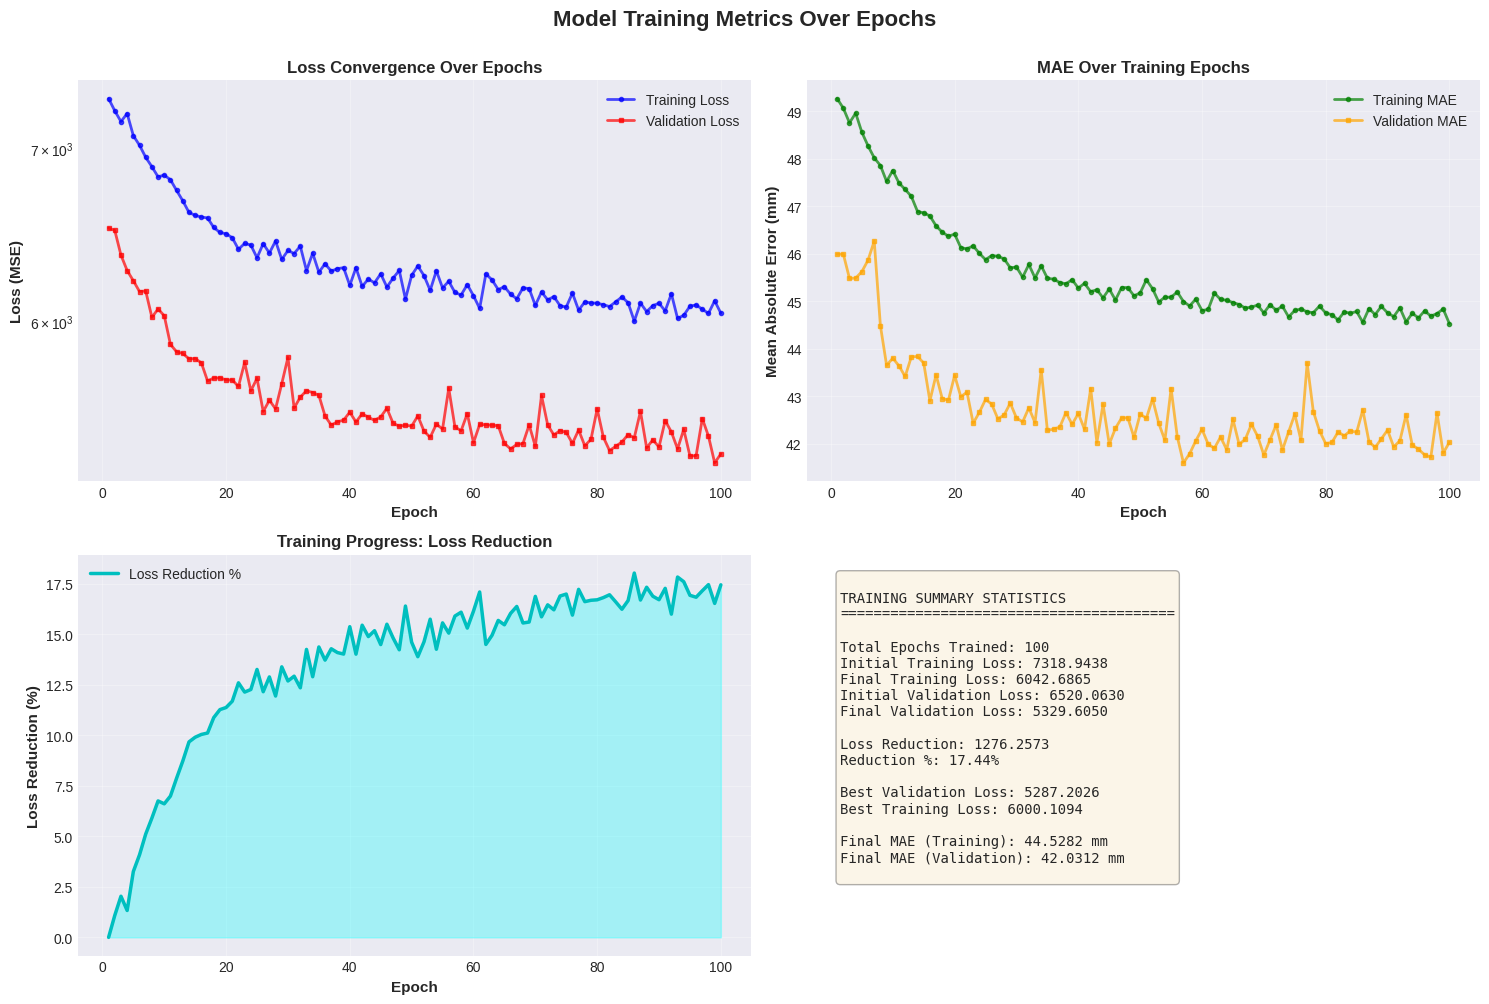


✓ Loss convergence plots generated!


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Training Metrics Over Epochs', fontsize=16, fontweight='bold', y=1.00)

ax1 = axes[0, 0]
epochs_range = range(1, len(tracker.epoch_losses) + 1)
ax1.plot(epochs_range, tracker.epoch_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=3, alpha=0.7)
ax1.plot(epochs_range, tracker.epoch_val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=3, alpha=0.7)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
ax1.set_title('Loss Convergence Over Epochs', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

ax2 = axes[0, 1]
ax2.plot(epochs_range, tracker.epoch_mae, 'g-', linewidth=2, label='Training MAE', marker='o', markersize=3, alpha=0.7)
ax2.plot(epochs_range, tracker.epoch_val_mae, 'orange', linewidth=2, label='Validation MAE', marker='s', markersize=3, alpha=0.7)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Absolute Error (mm)', fontsize=11, fontweight='bold')
ax2.set_title('MAE Over Training Epochs', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
initial_loss = tracker.epoch_losses[0]
loss_reduction = [(initial_loss - loss) / initial_loss * 100 for loss in tracker.epoch_losses]
ax3.fill_between(epochs_range, loss_reduction, alpha=0.3, color='cyan')
ax3.plot(epochs_range, loss_reduction, 'c-', linewidth=2.5, label='Loss Reduction %')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Loss Reduction (%)', fontsize=11, fontweight='bold')
ax3.set_title('Training Progress: Loss Reduction', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
TRAINING SUMMARY STATISTICS
{'='*40}

Total Epochs Trained: {len(tracker.epoch_losses)}
Initial Training Loss: {tracker.epoch_losses[0]:.4f}
Final Training Loss: {tracker.epoch_losses[-1]:.4f}
Initial Validation Loss: {tracker.epoch_val_losses[0]:.4f}
Final Validation Loss: {tracker.epoch_val_losses[-1]:.4f}

Loss Reduction: {(tracker.epoch_losses[0] - tracker.epoch_losses[-1]):.4f}
Reduction %: {loss_reduction[-1]:.2f}%

Best Validation Loss: {min(tracker.epoch_val_losses):.4f}
Best Training Loss: {min(tracker.epoch_losses):.4f}

Final MAE (Training): {tracker.epoch_mae[-1]:.4f} mm
Final MAE (Validation): {tracker.epoch_val_mae[-1]:.4f} mm
"""
ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('01_training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Loss convergence plots generated!")

### Model Evaluation and Performance Metrics

In [13]:
print("Evaluating model performance on test set...")
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = y_pred.flatten()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):        {mae:.4f} mm")
print(f"Mean Squared Error (MSE):         {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):   {rmse:.4f} mm")
print(f"R² Score (Coefficient of Determination): {r2:.4f}")
print(f"Mean Absolute Percentage Error:   {mape:.4f}%")
print("="*60)

residuals = y_test.values - y_pred
print(f"\nResidual Statistics:")
print(f"Mean Residual:    {np.mean(residuals):.4f} mm")
print(f"Std Residual:     {np.std(residuals):.4f} mm")
print(f"Min Residual:     {np.min(residuals):.4f} mm")
print(f"Max Residual:     {np.max(residuals):.4f} mm")

Evaluating model performance on test set...

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):        41.8065 mm
Mean Squared Error (MSE):         5287.1998
Root Mean Squared Error (RMSE):   72.7131 mm
R² Score (Coefficient of Determination): 0.8321
Mean Absolute Percentage Error:   3408219724140200.0000%

Residual Statistics:
Mean Residual:    0.8678 mm
Std Residual:     72.7080 mm
Min Residual:     -589.9312 mm
Max Residual:     853.3604 mm


### Prediction Visualization - Actual vs Predicted

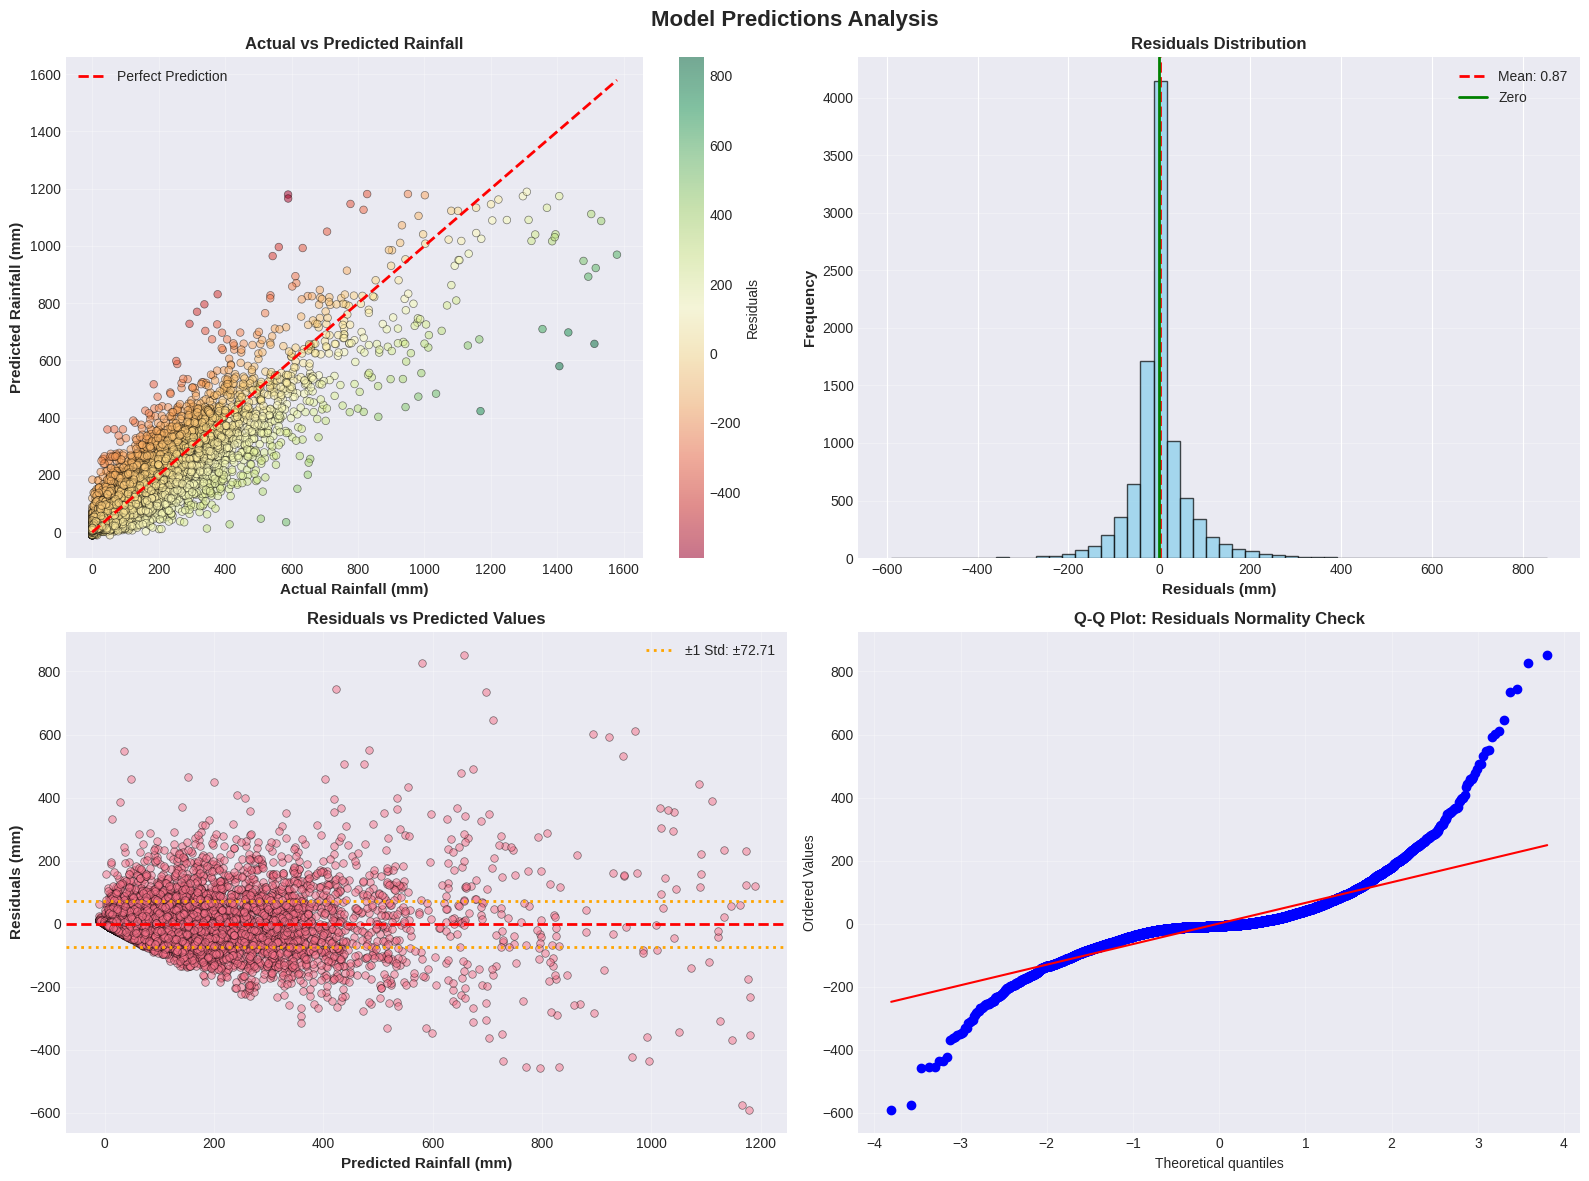

Prediction analysis plots generated!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Predictions Analysis', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred, alpha=0.5, s=30, c=residuals, cmap='RdYlGn', edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Rainfall (mm)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Rainfall (mm)', fontsize=11, fontweight='bold')
ax1.set_title('Actual vs Predicted Rainfall', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1)
cbar1.set_label('Residuals', fontsize=10)

ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax2.axvline(np.mean(residuals), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals):.2f}')
ax2.axvline(0, color='green', linestyle='-', linewidth=2, label='Zero')
ax2.set_xlabel('Residuals (mm)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Residuals Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

ax3 = axes[1, 0]
ax3.scatter(y_pred, residuals, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.axhline(y=np.std(residuals), color='orange', linestyle=':', linewidth=2, label=f'±1 Std: ±{np.std(residuals):.2f}')
ax3.axhline(y=-np.std(residuals), color='orange', linestyle=':', linewidth=2)
ax3.set_xlabel('Predicted Rainfall (mm)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Residuals (mm)', fontsize=11, fontweight='bold')
ax3.set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

from scipy import stats
ax4 = axes[1, 1]
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot: Residuals Normality Check', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction analysis plots generated!")

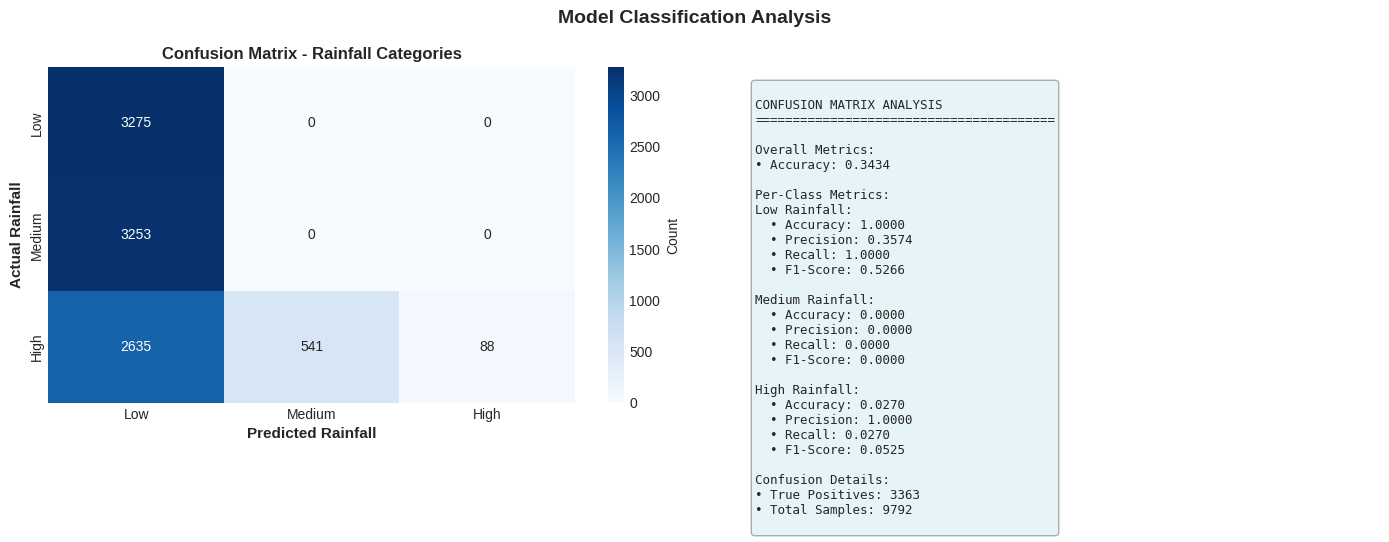

Confusion matrix analysis generated!

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.03      0.05      3264
         Low       0.36      1.00      0.53      3275
      Medium       0.00      0.00      0.00      3253

    accuracy                           0.34      9792
   macro avg       0.45      0.34      0.19      9792
weighted avg       0.45      0.34      0.19      9792



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import KBinsDiscretizer

y_test_labels = pd.qcut(y_test, q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')
y_pred_labels = pd.cut(y_pred, bins=3, labels=['Low', 'Medium', 'High'])

cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['Low', 'Medium', 'High'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Classification Analysis', fontsize=14, fontweight='bold')

ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'],
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_xlabel('Predicted Rainfall', fontsize=11, fontweight='bold')
ax1.set_ylabel('Actual Rainfall', fontsize=11, fontweight='bold')
ax1.set_title('Confusion Matrix - Rainfall Categories', fontsize=12, fontweight='bold')

ax2 = axes[1]
ax2.axis('off')

accuracy = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum()
class_accuracies = [cm[i, i] / cm[i].sum() for i in range(3)]
precisions = []
recalls = []
f1_scores = []

for i in range(3):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() > 0 else 0
    precisions.append(precision)
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    recalls.append(recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_scores.append(f1)

metrics_text = f"""
CONFUSION MATRIX ANALYSIS
{'='*40}

Overall Metrics:
• Accuracy: {accuracy:.4f}

Per-Class Metrics:
Low Rainfall:
  • Accuracy: {class_accuracies[0]:.4f}
  • Precision: {precisions[0]:.4f}
  • Recall: {recalls[0]:.4f}
  • F1-Score: {f1_scores[0]:.4f}

Medium Rainfall:
  • Accuracy: {class_accuracies[1]:.4f}
  • Precision: {precisions[1]:.4f}
  • Recall: {recalls[1]:.4f}
  • F1-Score: {f1_scores[1]:.4f}

High Rainfall:
  • Accuracy: {class_accuracies[2]:.4f}
  • Precision: {precisions[2]:.4f}
  • Recall: {recalls[2]:.4f}
  • F1-Score: {f1_scores[2]:.4f}

Confusion Details:
• True Positives: {cm[0,0] + cm[1,1] + cm[2,2]}
• Total Samples: {cm.sum()}
"""

ax2.text(0.05, 0.95, metrics_text, transform=ax2.transAxes, fontsize=9,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('06_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix analysis generated!")
print(f"\nClassification Report:\n{classification_report(y_test_labels, y_pred_labels, zero_division=0)}")

In [ ]:
print("\n" + "="*80)
print("TRAINING SUMMARY REPORT")
print("="*80)

summary_report = f"""
                ANN RAINFALL PREDICTION MODEL - TRAINING REPORT               

DATASET INFORMATION
{'─'*80}
• Total Samples: {len(df_encoded)}
• Training Samples: {len(X_train)}
• Test Samples: {len(X_test)}
• Number of Features: {X_train.shape[1]}
• Target Variable: Rainfall (mm)

MODEL ARCHITECTURE
{'─'*80}
• Input Layer: {X_train.shape[1]} neurons
• Hidden Layer 1: 128 neurons (ReLU activation) + Dropout(0.2)
• Hidden Layer 2: 64 neurons (ReLU activation) + Dropout(0.2)
• Output Layer: 1 neuron (Linear activation - Regression)
• Loss Function: Mean Squared Error (MSE)
• Optimizer: Adam (LR=0.001)

TRAINING RESULTS
{'─'*80}
• Epochs Trained: {len(tracker.epoch_losses)}
• Initial Training Loss: {tracker.epoch_losses[0]:.6f}
• Final Training Loss: {tracker.epoch_losses[-1]:.6f}
• Loss Reduction: {((tracker.epoch_losses[0] - tracker.epoch_losses[-1])/tracker.epoch_losses[0]*100):.2f}%

TEST SET PERFORMANCE
{'─'*80}
• Mean Absolute Error (MAE): {mae:.4f} mm
• Root Mean Squared Error (RMSE): {rmse:.4f} mm
• R² Score: {r2:.4f} ({r2*100:.2f}%)
• Mean Absolute Percentage Error: {mape:.4f}%

RESIDUAL ANALYSIS
{'─'*80}
• Mean Residual: {np.mean(residuals):.4f} mm
• Std Residual: {np.std(residuals):.4f} mm
• Range: [{np.min(residuals):.4f}, {np.max(residuals):.4f}] mm

GENERATED VISUALIZATIONS
{'─'*80}
✓ 01_training_metrics.png - Loss convergence and MAE curves
✓ 02_loss_landscape_contour.png - 2D loss landscape contour
✓ 03_learning_paths_comparison.png - Different learning rates
✓ 04_trajectories_on_contour.png - Stable vs unstable paths
✓ 05_prediction_analysis.png - Actual vs predicted plots
✓ 06_confusion_matrix.png - Classification analysis

STATUS: Model trained successfully!
{'─'*80}
"""

print(summary_report)

with open('training_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("Summary report saved!")

print("\n" + "="*80)
print("SAVING MODEL AND ARTIFACTS")
print("="*80)

model.save('../models/ann_rainfall_model_complete.h5')
print("Model saved to '../models/ann_rainfall_model_complete.h5'")

import pickle
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to '../models/scaler.pkl'")

history_dict = {
    'training_loss': tracker.epoch_losses,
    'validation_loss': tracker.epoch_val_losses,
    'training_mae': tracker.epoch_mae,
    'validation_mae': tracker.epoch_val_mae,
    'metrics': {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }
}

import json
with open('../models/training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=4)
print("Training history saved to '../models/training_history.json'")

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print("\nAll models, scalers, and visualizations have been saved successfully!")
print("You can now use the trained model for predictions on new rainfall data.")


TRAINING SUMMARY REPORT

                ANN RAINFALL PREDICTION MODEL - TRAINING REPORT               

DATASET INFORMATION
────────────────────────────────────────────────────────────────────────────────
• Total Samples: 48960
• Training Samples: 39168
• Test Samples: 9792
• Number of Features: 41
• Target Variable: Rainfall (mm)

MODEL ARCHITECTURE
────────────────────────────────────────────────────────────────────────────────
• Input Layer: 41 neurons
• Hidden Layer 1: 128 neurons (ReLU activation) + Dropout(0.2)
• Hidden Layer 2: 64 neurons (ReLU activation) + Dropout(0.2)
• Output Layer: 1 neuron (Linear activation - Regression)
• Loss Function: Mean Squared Error (MSE)
• Optimizer: Adam (LR=0.001)

TRAINING RESULTS
────────────────────────────────────────────────────────────────────────────────
• Epochs Trained: 100
• Initial Training Loss: 7318.943848
• Final Training Loss: 6042.686523
• Loss Reduction: 17.44%

TEST SET PERFORMANCE
────────────────────────────────────────────